We're going to first try training a CNN on the individual images.
We will be using binary cross entropy across the 17 regions.

In [1]:
import HelperFuncs as hfuncs
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.data_utils import Sequence
import h5py
import os

BATCH_SIZE = 1
FINAL_WIDTH = 400
FINAL_HEIGHT = 600
CHANNELS = 1
ZONES = 17
ANGLES = 4 #Just using 4 angles here
#Create directories for sequencer function if they don't exist
for d in ['temp/train_scan/','temp/test_scan/','temp/val_scan/']:
    if not os.path.isdir(d):
        print("Created directory: {}".format(d))
        os.makedirs(d)
        
class LegScanSequencer(Sequence):
    idx_dict={}
    
    def __init__(self,num_batches,bucket_name,mode="train_scan"):
        self.num_batches = num_batches
        self.bucket_name = bucket_name
        self.mode = mode
        self.key_id, self.secret_key = hfuncs.GetAWSCredentials()
        self.mode = mode
        self.angles = np.arange(0,64,64//ANGLES)
    def __len__(self):
        return self.num_batches
    def on_epoch_end(self):
        pass
    def __getitem__(self,idx):
        #Get Client
        client = hfuncs.GetAWSClient(self.key_id,self.secret_key)
        bucket = client.Bucket(self.bucket_name)
        
        #Initialize vectors
        X_train = np.zeros((BATCH_SIZE,ANGLES,FINAL_WIDTH,FINAL_HEIGHT//2,CHANNELS))
        y_train = np.zeros((BATCH_SIZE,1))
        
        j=0
        for i in range(idx*BATCH_SIZE,(idx+1)*BATCH_SIZE):
            #Download batch at index
            path = "temp/{}/batch_{}.hdf5".format(self.mode,i)
            key = "{}/batch_{}.hdf5".format(self.mode,i)
            bucket.download_file(Key=key,Filename=path)
        
            f = h5py.File(path,"r")
            try:
                X_train[j,:,:,:,:] = f['/image'].value[self.angles,:,:FINAL_HEIGHT//2,:]
                r_leg = [12,14,13,15]
                l_leg = [13,15]
                r_y = np.amax(f['/labels'].value[r_leg])
                #l_y = np.amax(f['/labels'].value[l_leg])
                y_train[j,:] = r_y
                j += 1
            finally:
                f.close()
                os.remove(path) 
        return X_train, y_train



Using TensorFlow backend.


In [157]:
#Test how many positive samples
import pickle
labels = hfuncs.GetLabelsDict(r'stage1_labels.csv')
filename = "data_separated.pickle"
with open(filename,"rb") as f:
   save = pickle.load(f)
   K_test= save['K_test']
   K_val = save['K_val']
   K_train = save['K_train']
s = 0
pos = 0
for k in K_train:
    k_clean = k.replace("DHSData/","").replace(".a3daps","")
    if k_clean in labels.keys():
        label = np.array(labels[k_clean])
        val = np.amax(label[[12,14]])
        if val == 1:
            s += 1
            pos += 1
        else:
            s += 1
print("total={},pos={}".format(s,pos))

total=687,pos=126


In [2]:
from sklearn.ensemble import GradientBoostingClassifier
import os
import h5py

#Bucket with clean data
UPLOAD_BUCKET = 'cleandhsdata' #bucket where clean data was stored
TEMP_DIR = 'temp' #Directory for file upload/downloads
key_id, secret_key = hfuncs.GetAWSCredentials()
client = hfuncs.GetAWSClient(key_id,secret_key)
bucket = client.Bucket(UPLOAD_BUCKET)

#Grab train data
#Download dataset
print("Downloading dataset...")
mode = 'train'
dir_name = 'fullfeatureextraction'
key_suffix = "{}_data.hdf5".format(mode)
filename = os.path.join(TEMP_DIR,key_suffix)
key = "{}/{}".format(dir_name,key_suffix)

if not os.path.exists(filename):
    bucket.download_file(Key=key,Filename=filename)

#Open downloaded file and load data
with h5py.File(filename,"r") as f:    
    #Get train data
    print("Reading data...")
    
    d = f['/features']
    X_train = d[:]
  
    d = f['/labels']
    y_train = d[:]

#Grab val data
#Download dataset
print("Downloading dataset...")
mode = 'val'
dir_name = 'fullfeatureextraction'
key_suffix = "{}_data.hdf5".format(mode)
filename = os.path.join(TEMP_DIR,key_suffix)
key = "{}/{}".format(dir_name,key_suffix)

if not os.path.exists(filename):
    bucket.download_file(Key=key,Filename=filename)
    
#Open downloaded file and load data
with h5py.File(filename,"r") as f:    
    #Get train data
    print("Reading data...")
    
    d = f['/features']
    X_val = d[:]
  
    d = f['/labels']
    y_val = d[:]
    


Reading data...
Reading data...


In [7]:
clf = GradientBoostingClassifier(n_estimators=300,max_depth=5,verbose=1)

print("Fitting data...")
clf.fit(X_train,y_train)

print("Calculating train score...")
print(clf.score(X_train,y_train))

print("Calculating validation score...")
print(clf.score(X_val,y_val))

KeyboardInterrupt: 

In [3]:
#For every layer in the data set, we're going to train a gardient booster classifier 
#using hyperparameters we selected from before
import gc
import sys
import os

xgboost_dir = '/home/ubuntu/xgboost/python-package'
if xgboost_dir not in sys.path:
    sys.path.append(xgboost_dir)

import xgboost as xgb
from xgboost import XGBClassifier

In [13]:

  
clf = XGBClassifier(min_samples_split=3,max_depth=5,learning_rate=0.1,n_estimators=200,silent=False,njobs=2)
#Fit model    
print("Fitting model...")
clf.fit(X_train,y_train,eval_set = [(X_train,y_train),(X_val,y_val)],
        eval_metric = "logloss",
        early_stopping_rounds = 10,
        verbose=True )

#Val score
results = clf.evals_result()       




Fitting model...
[0]	validation_0-logloss:0.633849	validation_1-logloss:0.663124
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.585064	validation_1-logloss:0.64229
[2]	validation_0-logloss:0.544203	validation_1-logloss:0.621409
[3]	validation_0-logloss:0.499781	validation_1-logloss:0.601835
[4]	validation_0-logloss:0.461669	validation_1-logloss:0.58445
[5]	validation_0-logloss:0.432416	validation_1-logloss:0.571932
[6]	validation_0-logloss:0.406431	validation_1-logloss:0.559709
[7]	validation_0-logloss:0.37599	validation_1-logloss:0.54807
[8]	validation_0-logloss:0.358102	validation_1-logloss:0.538443
[9]	validation_0-logloss:0.336041	validation_1-logloss:0.534222
[10]	validation_0-logloss:0.314169	validation_1-logloss:0.528362
[11]	validation_0-logloss:0.295364	validation_1-logloss:0.520744
[12]	validation_0-logloss:0.279742	validation_1-logl

In [14]:
clf = XGBClassifier(min_samples_split=3,max_depth=3,learning_rate=0.05,n_estimators=200,silent=False,njobs=2)
#Fit model    
print("Fitting model...")
clf.fit(X_train,y_train,eval_set = [(X_train,y_train),(X_val,y_val)],
        eval_metric = "logloss",
        early_stopping_rounds = 20,
        verbose=True )

Fitting model...
[0]	validation_0-logloss:0.673395	validation_1-logloss:0.678392
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.655057	validation_1-logloss:0.665139
[2]	validation_0-logloss:0.638376	validation_1-logloss:0.652409
[3]	validation_0-logloss:0.621906	validation_1-logloss:0.641344
[4]	validation_0-logloss:0.607772	validation_1-logloss:0.632464
[5]	validation_0-logloss:0.593177	validation_1-logloss:0.622084
[6]	validation_0-logloss:0.579486	validation_1-logloss:0.612543
[7]	validation_0-logloss:0.566734	validation_1-logloss:0.603906
[8]	validation_0-logloss:0.555416	validation_1-logloss:0.596737
[9]	validation_0-logloss:0.544023	validation_1-logloss:0.589366
[10]	validation_0-logloss:0.532565	validation_1-logloss:0.580394
[11]	validation_0-logloss:0.522959	validation_1-logloss:0.57319
[12]	validation_0-logloss:0.513264	validation_1-l

[124]	validation_0-logloss:0.12765	validation_1-logloss:0.427723
[125]	validation_0-logloss:0.126083	validation_1-logloss:0.428417
[126]	validation_0-logloss:0.124548	validation_1-logloss:0.429044
[127]	validation_0-logloss:0.123289	validation_1-logloss:0.428049
[128]	validation_0-logloss:0.121767	validation_1-logloss:0.427055
[129]	validation_0-logloss:0.120376	validation_1-logloss:0.425509
[130]	validation_0-logloss:0.119143	validation_1-logloss:0.425258
[131]	validation_0-logloss:0.117718	validation_1-logloss:0.425678
[132]	validation_0-logloss:0.116301	validation_1-logloss:0.425013
[133]	validation_0-logloss:0.115328	validation_1-logloss:0.424658
[134]	validation_0-logloss:0.113788	validation_1-logloss:0.423525
[135]	validation_0-logloss:0.112346	validation_1-logloss:0.42201
[136]	validation_0-logloss:0.111214	validation_1-logloss:0.421917
[137]	validation_0-logloss:0.110075	validation_1-logloss:0.421786
[138]	validation_0-logloss:0.108687	validation_1-logloss:0.421719
[139]	valida

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, min_samples_split=3, missing=None,
       n_estimators=200, n_jobs=1, njobs=2, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=False,
       subsample=1)

In [18]:
clf = XGBClassifier(min_samples_split=3,gamma=10,max_depth=3,learning_rate=0.10,n_estimators=300,silent=False,njobs=2)
#Fit model    
print("Fitting model...")
clf.fit(X_train,y_train,eval_set = [(X_train,y_train),(X_val,y_val)],
        eval_metric = "logloss",
        early_stopping_rounds = 20,
        verbose=True )

Fitting model...
[0]	validation_0-logloss:0.654622	validation_1-logloss:0.66457
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 20 rounds.
[1]	validation_0-logloss:0.621505	validation_1-logloss:0.64122
[2]	validation_0-logloss:0.591284	validation_1-logloss:0.621398
[3]	validation_0-logloss:0.56757	validation_1-logloss:0.606733
[4]	validation_0-logloss:0.543496	validation_1-logloss:0.59035
[5]	validation_0-logloss:0.523767	validation_1-logloss:0.576009
[6]	validation_0-logloss:0.506761	validation_1-logloss:0.565608
[7]	validation_0-logloss:0.487805	validation_1-logloss:0.551633
[8]	validation_0-logloss:0.471956	validation_1-logloss:0.544442
[9]	validation_0-logloss:0.455698	validation_1-logloss:0.53687
[10]	validation_0-logloss:0.442344	validation_1-logloss:0.527914
[11]	validation_0-logloss:0.431923	validation_1-logloss:0.518841
[12]	validation_0-logloss:0.421109	validation_1-loglo

KeyboardInterrupt: 

In [19]:
clf = XGBClassifier(min_samples_split=3,gamma=4,max_depth=3,learning_rate=0.10,n_estimators=300,silent=False,njobs=2)
#Fit model    
print("Fitting model...")
clf.fit(X_train,y_train,eval_set = [(X_train,y_train),(X_val,y_val)],
        eval_metric = "logloss",
        early_stopping_rounds = 20,
        verbose=True )

Fitting model...
[0]	validation_0-logloss:0.654622	validation_1-logloss:0.66457
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 20 rounds.
[1]	validation_0-logloss:0.621505	validation_1-logloss:0.64122
[2]	validation_0-logloss:0.591284	validation_1-logloss:0.621398
[3]	validation_0-logloss:0.567094	validation_1-logloss:0.607047
[4]	validation_0-logloss:0.543077	validation_1-logloss:0.590667
[5]	validation_0-logloss:0.522029	validation_1-logloss:0.576121
[6]	validation_0-logloss:0.50378	validation_1-logloss:0.565698
[7]	validation_0-logloss:0.485008	validation_1-logloss:0.551772
[8]	validation_0-logloss:0.468957	validation_1-logloss:0.54427
[9]	validation_0-logloss:0.453637	validation_1-logloss:0.538047
[10]	validation_0-logloss:0.440368	validation_1-logloss:0.528571
[11]	validation_0-logloss:0.426172	validation_1-logloss:0.520141
[12]	validation_0-logloss:0.41544	validation_1-loglo

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=4, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, min_samples_split=3, missing=None,
       n_estimators=300, n_jobs=1, njobs=2, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=False,
       subsample=1)

In [21]:
clf = XGBClassifier(min_samples_split=3,gamma=16,max_depth=10,learning_rate=0.10,n_estimators=300,silent=False,njobs=2)
#Fit model    
print("Fitting model...")
clf.fit(X_train,y_train,eval_set = [(X_train,y_train),(X_val,y_val)],
        eval_metric = "logloss",
        early_stopping_rounds = 20,
        verbose=True )

Fitting model...
[0]	validation_0-logloss:0.639439	validation_1-logloss:0.663976
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 20 rounds.
[1]	validation_0-logloss:0.592547	validation_1-logloss:0.641758
[2]	validation_0-logloss:0.556509	validation_1-logloss:0.617155
[3]	validation_0-logloss:0.518467	validation_1-logloss:0.600357
[4]	validation_0-logloss:0.48991	validation_1-logloss:0.587115
[5]	validation_0-logloss:0.469162	validation_1-logloss:0.57348
[6]	validation_0-logloss:0.452682	validation_1-logloss:0.563182
[7]	validation_0-logloss:0.438712	validation_1-logloss:0.550635
[8]	validation_0-logloss:0.430047	validation_1-logloss:0.542604
[9]	validation_0-logloss:0.418589	validation_1-logloss:0.534922
[10]	validation_0-logloss:0.405425	validation_1-logloss:0.525949
[11]	validation_0-logloss:0.393774	validation_1-logloss:0.51856
[12]	validation_0-logloss:0.380421	validation_1-log

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=16, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, min_samples_split=3, missing=None,
       n_estimators=300, n_jobs=1, njobs=2, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=False,
       subsample=1)

In [22]:
clf = XGBClassifier(min_child_weight=3,gamma=16,max_depth=10,learning_rate=0.10,n_estimators=300,silent=False,njobs=2)
#Fit model    
print("Fitting model...")
clf.fit(X_train,y_train,eval_set = [(X_train,y_train),(X_val,y_val)],
        eval_metric = "logloss",
        early_stopping_rounds = 10,
        verbose=True )

Fitting model...
[0]	validation_0-logloss:0.641156	validation_1-logloss:0.664051
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.597719	validation_1-logloss:0.644602
[2]	validation_0-logloss:0.563301	validation_1-logloss:0.622152
[3]	validation_0-logloss:0.52746	validation_1-logloss:0.606226
[4]	validation_0-logloss:0.502569	validation_1-logloss:0.588031
[5]	validation_0-logloss:0.48068	validation_1-logloss:0.575936
[6]	validation_0-logloss:0.461457	validation_1-logloss:0.560035
[7]	validation_0-logloss:0.441675	validation_1-logloss:0.547485
[8]	validation_0-logloss:0.43099	validation_1-logloss:0.537597
[9]	validation_0-logloss:0.416166	validation_1-logloss:0.529518
[10]	validation_0-logloss:0.404914	validation_1-logloss:0.521309
[11]	validation_0-logloss:0.388467	validation_1-logloss:0.511893
[12]	validation_0-logloss:0.377094	validation_1-log

KeyboardInterrupt: 

In [ ]:
clf = XGBClassifier(colsample_bytree=.50,min_child_weight=5,gamma=4,max_depth=15,
                    learning_rate=0.10,n_estimators=100,silent=False,njobs=2,scale_pos_weight=0.64)
#Fit model    
print("Fitting model...")
clf.fit(X_train,y_train,eval_set = [(X_train,y_train),(X_val,y_val)],
        eval_metric = "logloss",
        early_stopping_rounds = 10,
        verbose=True )

In [53]:
clf = XGBClassifier(subsample=0.8,colsample_bytree=0.5,min_child_weight=1,gamma=8,max_depth=3,learning_rate=0.10,n_estimators=200,silent=False,njobs=6)
#Fit model    
print("Fitting model...")
clf.fit(X_train,y_train,eval_set = [(X_train,y_train),(X_val,y_val)],
        eval_metric = "logloss",
        early_stopping_rounds = 25,
        verbose=True )

Fitting model...
[0]	validation_0-logloss:0.655761	validation_1-logloss:0.66693
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 25 rounds.
[1]	validation_0-logloss:0.623769	validation_1-logloss:0.641349
[2]	validation_0-logloss:0.59644	validation_1-logloss:0.6228
[3]	validation_0-logloss:0.571726	validation_1-logloss:0.601746
[4]	validation_0-logloss:0.552246	validation_1-logloss:0.583517
[5]	validation_0-logloss:0.534202	validation_1-logloss:0.570044
[6]	validation_0-logloss:0.513759	validation_1-logloss:0.554521
[7]	validation_0-logloss:0.494864	validation_1-logloss:0.546916
[8]	validation_0-logloss:0.479239	validation_1-logloss:0.537665
[9]	validation_0-logloss:0.465544	validation_1-logloss:0.527908
[10]	validation_0-logloss:0.452819	validation_1-logloss:0.523467
[11]	validation_0-logloss:0.438772	validation_1-logloss:0.519164
[12]	validation_0-logloss:0.426938	validation_1-logl

Stopping. Best iteration:
[98]	validation_0-logloss:0.17081	validation_1-logloss:0.434439



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=8, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, njobs=6, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=False, subsample=0.8)

In [45]:
clf = XGBClassifier(colsample_bytree=0.25,colsample_bylevel=0.5,min_child_weight=1,gamma=8,max_depth=3,learning_rate=0.10,n_estimators=200,silent=False,njobs=6)
#Fit model    
print("Fitting model...")
clf.fit(X_train,y_train,eval_set = [(X_train,y_train),(X_val,y_val)],
        eval_metric = "logloss",
        early_stopping_rounds = 25,
        verbose=True )

Fitting model...
[0]	validation_0-logloss:0.666529	validation_1-logloss:0.677487
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 25 rounds.
[1]	validation_0-logloss:0.635425	validation_1-logloss:0.662228
[2]	validation_0-logloss:0.610479	validation_1-logloss:0.646859
[3]	validation_0-logloss:0.585657	validation_1-logloss:0.629892
[4]	validation_0-logloss:0.562291	validation_1-logloss:0.610298
[5]	validation_0-logloss:0.542853	validation_1-logloss:0.594855
[6]	validation_0-logloss:0.522979	validation_1-logloss:0.583232
[7]	validation_0-logloss:0.506857	validation_1-logloss:0.575362
[8]	validation_0-logloss:0.49218	validation_1-logloss:0.568877
[9]	validation_0-logloss:0.47802	validation_1-logloss:0.561099
[10]	validation_0-logloss:0.463382	validation_1-logloss:0.550763
[11]	validation_0-logloss:0.451952	validation_1-logloss:0.544078
[12]	validation_0-logloss:0.440385	validation_1-lo

[124]	validation_0-logloss:0.181601	validation_1-logloss:0.436589
[125]	validation_0-logloss:0.181601	validation_1-logloss:0.436589
[126]	validation_0-logloss:0.181601	validation_1-logloss:0.436588
[127]	validation_0-logloss:0.181601	validation_1-logloss:0.436587
[128]	validation_0-logloss:0.181601	validation_1-logloss:0.436587
[129]	validation_0-logloss:0.181601	validation_1-logloss:0.436586
[130]	validation_0-logloss:0.181601	validation_1-logloss:0.436586
[131]	validation_0-logloss:0.181601	validation_1-logloss:0.436586
[132]	validation_0-logloss:0.181601	validation_1-logloss:0.436585
[133]	validation_0-logloss:0.17946	validation_1-logloss:0.436086
[134]	validation_0-logloss:0.17946	validation_1-logloss:0.436085
[135]	validation_0-logloss:0.177317	validation_1-logloss:0.43545
[136]	validation_0-logloss:0.177317	validation_1-logloss:0.435449
[137]	validation_0-logloss:0.177317	validation_1-logloss:0.435449
[138]	validation_0-logloss:0.177317	validation_1-logloss:0.435448
[139]	validat

KeyboardInterrupt: 

In [5]:
clf = XGBClassifier(booster='dart',rate_drop=0.10,colsample_bytree=0.50,subsample=0.8,min_child_weight=2,gamma=1,max_depth=10,
                    learning_rate=0.1,n_estimators=500,silent=False,njobs=6,scale_pos_weight=0.64)
#Fit model    
print("Fitting model...")
clf.fit(X_train,y_train,eval_set = [(X_train,y_train),(X_val,y_val)],
        eval_metric = "error",
        early_stopping_rounds = 25,
        verbose=True )

Fitting model...
[0]	validation_0-error:0.135802	validation_1-error:0.299107
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 25 rounds.
[1]	validation_0-error:0.090909	validation_1-error:0.254464
[2]	validation_0-error:0.089787	validation_1-error:0.303571
[3]	validation_0-error:0.046016	validation_1-error:0.254464
[4]	validation_0-error:0.029181	validation_1-error:0.294643
[5]	validation_0-error:0.03367	validation_1-error:0.236607
[6]	validation_0-error:0.037037	validation_1-error:0.21875
[7]	validation_0-error:0.022447	validation_1-error:0.232143
[8]	validation_0-error:0.011223	validation_1-error:0.254464
[9]	validation_0-error:0.006734	validation_1-error:0.227679
[10]	validation_0-error:0.013468	validation_1-error:0.245536


KeyboardInterrupt: 

In [5]:
clf = XGBClassifier(booster='gblinear',reg_lambda=10,reg_alpha=2,subsample=0.8,learning_rate=0.10,n_estimators=200,silent=False,njobs=4)
#Fit model    
print("Fitting model...")
clf.fit(X_train,y_train,eval_set = [(X_train,y_train),(X_val,y_val)],
        eval_metric = "logloss",
        early_stopping_rounds = 10,
        verbose=True )

Fitting model...
[0]	validation_0-logloss:0.265858	validation_1-logloss:0.433026
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.166158	validation_1-logloss:0.388689
[2]	validation_0-logloss:0.125814	validation_1-logloss:0.372435
[3]	validation_0-logloss:0.107251	validation_1-logloss:0.364431
[4]	validation_0-logloss:0.097437	validation_1-logloss:0.359509
[5]	validation_0-logloss:0.091631	validation_1-logloss:0.356167
[6]	validation_0-logloss:0.087884	validation_1-logloss:0.35366
[7]	validation_0-logloss:0.085275	validation_1-logloss:0.351675
[8]	validation_0-logloss:0.08333	validation_1-logloss:0.350064
[9]	validation_0-logloss:0.081792	validation_1-logloss:0.34871
[10]	validation_0-logloss:0.080522	validation_1-logloss:0.347545
[11]	validation_0-logloss:0.079434	validation_1-logloss:0.346523
[12]	validation_0-logloss:0.078474	validation_1-log

XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, njobs=4, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=2, reg_lambda=10, scale_pos_weight=1,
       seed=None, silent=False, subsample=0.8)

In [9]:
clf = XGBClassifier(booster='gblinear',reg_lambda=10,reg_alpha=3,subsample=0.5,learning_rate=0.10,n_estimators=200,silent=False,njobs=4)
#Fit model    
print("Fitting model...")
clf.fit(X_train,y_train,eval_set = [(X_train,y_train),(X_val,y_val)],
        eval_metric = "logloss",
        early_stopping_rounds = 20,
        verbose=True )

Fitting model...
[0]	validation_0-logloss:0.29572	validation_1-logloss:0.438437
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 20 rounds.
[1]	validation_0-logloss:0.203045	validation_1-logloss:0.394233
[2]	validation_0-logloss:0.164405	validation_1-logloss:0.377068
[3]	validation_0-logloss:0.145347	validation_1-logloss:0.368332
[4]	validation_0-logloss:0.134485	validation_1-logloss:0.363133
[5]	validation_0-logloss:0.127604	validation_1-logloss:0.359685
[6]	validation_0-logloss:0.122878	validation_1-logloss:0.357216
[7]	validation_0-logloss:0.119421	validation_1-logloss:0.355323
[8]	validation_0-logloss:0.116751	validation_1-logloss:0.35381
[9]	validation_0-logloss:0.114603	validation_1-logloss:0.35255
[10]	validation_0-logloss:0.112811	validation_1-logloss:0.351467
[11]	validation_0-logloss:0.111272	validation_1-logloss:0.350517
[12]	validation_0-logloss:0.109919	validation_1-log

XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, njobs=4, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=3, reg_lambda=10, scale_pos_weight=1,
       seed=None, silent=False, subsample=0.5)

In [10]:
clf = XGBClassifier(booster='gblinear',reg_lambda=10,reg_alpha=2,subsample=0.5,learning_rate=0.10,n_estimators=200,silent=False,njobs=4)
#Fit model    
print("Fitting model...")
clf.fit(X_train,y_train,eval_set = [(X_train,y_train),(X_val,y_val)],
        eval_metric = "logloss",
        early_stopping_rounds = 20,
        verbose=True )

Fitting model...
[0]	validation_0-logloss:0.265858	validation_1-logloss:0.433026
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 20 rounds.
[1]	validation_0-logloss:0.166158	validation_1-logloss:0.388689
[2]	validation_0-logloss:0.125814	validation_1-logloss:0.372435
[3]	validation_0-logloss:0.107251	validation_1-logloss:0.364431
[4]	validation_0-logloss:0.097437	validation_1-logloss:0.359509
[5]	validation_0-logloss:0.091631	validation_1-logloss:0.356167
[6]	validation_0-logloss:0.087884	validation_1-logloss:0.35366
[7]	validation_0-logloss:0.085275	validation_1-logloss:0.351675
[8]	validation_0-logloss:0.08333	validation_1-logloss:0.350064
[9]	validation_0-logloss:0.081792	validation_1-logloss:0.34871
[10]	validation_0-logloss:0.080522	validation_1-logloss:0.347545
[11]	validation_0-logloss:0.079434	validation_1-logloss:0.346523
[12]	validation_0-logloss:0.078474	validation_1-log

XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, njobs=4, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=2, reg_lambda=10, scale_pos_weight=1,
       seed=None, silent=False, subsample=0.5)

In [11]:
clf = XGBClassifier(booster='gblinear',reg_lambda=8,reg_alpha=2,subsample=0.5,learning_rate=0.10,n_estimators=200,silent=False,njobs=4)
#Fit model    
print("Fitting model...")
clf.fit(X_train,y_train,eval_set = [(X_train,y_train),(X_val,y_val)],
        eval_metric = "logloss",
        early_stopping_rounds = 20,
        verbose=True )

Fitting model...
[0]	validation_0-logloss:0.264311	validation_1-logloss:0.43306
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 20 rounds.
[1]	validation_0-logloss:0.164553	validation_1-logloss:0.388749
[2]	validation_0-logloss:0.124309	validation_1-logloss:0.372499
[3]	validation_0-logloss:0.10589	validation_1-logloss:0.364493
[4]	validation_0-logloss:0.096193	validation_1-logloss:0.35956
[5]	validation_0-logloss:0.090472	validation_1-logloss:0.3562
[6]	validation_0-logloss:0.086783	validation_1-logloss:0.353661
[7]	validation_0-logloss:0.08421	validation_1-logloss:0.351656
[8]	validation_0-logloss:0.082286	validation_1-logloss:0.350026
[9]	validation_0-logloss:0.08076	validation_1-logloss:0.348649
[10]	validation_0-logloss:0.079495	validation_1-logloss:0.347457
[11]	validation_0-logloss:0.078408	validation_1-logloss:0.346413
[12]	validation_0-logloss:0.077445	validation_1-logloss

XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, njobs=4, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=2, reg_lambda=8, scale_pos_weight=1,
       seed=None, silent=False, subsample=0.5)

In [27]:
clf = XGBClassifier(booster='gblinear',reg_lambda=2,reg_alpha=2,subsample=0.5,learning_rate=0.05,
                    n_estimators=200,silent=False,njobs=4,scale_pos_weight=1/2)
#Fit model    
print("Fitting model...")
clf.fit(X_train,y_train,eval_set = [(X_train,y_train),(X_val,y_val)],
        eval_metric = "logloss",
        early_stopping_rounds = 20,
        verbose=True )

Fitting model...
[0]	validation_0-logloss:0.347121	validation_1-logloss:0.480158
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 20 rounds.
[1]	validation_0-logloss:0.253061	validation_1-logloss:0.430136
[2]	validation_0-logloss:0.207072	validation_1-logloss:0.405936
[3]	validation_0-logloss:0.180611	validation_1-logloss:0.391621
[4]	validation_0-logloss:0.163789	validation_1-logloss:0.382391
[5]	validation_0-logloss:0.152309	validation_1-logloss:0.376073
[6]	validation_0-logloss:0.144056	validation_1-logloss:0.37149
[7]	validation_0-logloss:0.13787	validation_1-logloss:0.368004
[8]	validation_0-logloss:0.133068	validation_1-logloss:0.365223
[9]	validation_0-logloss:0.129243	validation_1-logloss:0.362941
[10]	validation_0-logloss:0.126124	validation_1-logloss:0.361035
[11]	validation_0-logloss:0.12353	validation_1-logloss:0.359413
[12]	validation_0-logloss:0.121336	validation_1-log

XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, njobs=4, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=2, reg_lambda=2, scale_pos_weight=0.5,
       seed=None, silent=False, subsample=0.5)

In [7]:
clf = XGBClassifier(booster='gblinear',reg_lambda=2,reg_alpha=0.75,learning_rate=0.02,
                    n_estimators=500,silent=False,njobs=4,scale_pos_weight=1/2)
#Fit model    
print("Fitting model...")
clf.fit(X_train,y_train,eval_set = [(X_train,y_train),(X_val,y_val)],
        eval_metric = "logloss",
        early_stopping_rounds = 20,
        verbose=True )

Fitting model...
[0]	validation_0-logloss:0.391451	validation_1-logloss:0.508905
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 20 rounds.
[1]	validation_0-logloss:0.281656	validation_1-logloss:0.449133
[2]	validation_0-logloss:0.217424	validation_1-logloss:0.416516
[3]	validation_0-logloss:0.17588	validation_1-logloss:0.396578
[4]	validation_0-logloss:0.147551	validation_1-logloss:0.383746
[5]	validation_0-logloss:0.12747	validation_1-logloss:0.375101
[6]	validation_0-logloss:0.112764	validation_1-logloss:0.369045
[7]	validation_0-logloss:0.101694	validation_1-logloss:0.364646
[8]	validation_0-logloss:0.093161	validation_1-logloss:0.361325
[9]	validation_0-logloss:0.086453	validation_1-logloss:0.358747
[10]	validation_0-logloss:0.081088	validation_1-logloss:0.356696
[11]	validation_0-logloss:0.076727	validation_1-logloss:0.354998
[12]	validation_0-logloss:0.073135	validation_1-lo

[124]	validation_0-logloss:0.040683	validation_1-logloss:0.330777
[125]	validation_0-logloss:0.040624	validation_1-logloss:0.330749
[126]	validation_0-logloss:0.040566	validation_1-logloss:0.330723
[127]	validation_0-logloss:0.040508	validation_1-logloss:0.330698
[128]	validation_0-logloss:0.040451	validation_1-logloss:0.330675
[129]	validation_0-logloss:0.040395	validation_1-logloss:0.330653
[130]	validation_0-logloss:0.040339	validation_1-logloss:0.330633
[131]	validation_0-logloss:0.040283	validation_1-logloss:0.330614
[132]	validation_0-logloss:0.040228	validation_1-logloss:0.330596
[133]	validation_0-logloss:0.040174	validation_1-logloss:0.33058
[134]	validation_0-logloss:0.04012	validation_1-logloss:0.330565
[135]	validation_0-logloss:0.040067	validation_1-logloss:0.330551
[136]	validation_0-logloss:0.040014	validation_1-logloss:0.330539
[137]	validation_0-logloss:0.039962	validation_1-logloss:0.330528
[138]	validation_0-logloss:0.039911	validation_1-logloss:0.330518
[139]	valida

XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.02, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, njobs=4, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0.75, reg_lambda=2, scale_pos_weight=0.5,
       seed=None, silent=False, subsample=1)

In [36]:
clf = XGBClassifier(booster='gblinear',reg_alpha=0.80,learning_rate=0.1,
                    n_estimators=500,silent=False,njobs=4,scale_pos_weight=0.64)
#Fit model    
print("Fitting model...")
clf.fit(X_train,y_train,eval_set = [(X_train,y_train),(X_val,y_val)],
        eval_metric = "logloss",
        early_stopping_rounds = 20,
        verbose=True )

Fitting model...
[0]	validation_0-logloss:0.219264	validation_1-logloss:0.437721
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 20 rounds.
[1]	validation_0-logloss:0.115489	validation_1-logloss:0.390152
[2]	validation_0-logloss:0.075903	validation_1-logloss:0.374328
[3]	validation_0-logloss:0.059562	validation_1-logloss:0.366827
[4]	validation_0-logloss:0.052047	validation_1-logloss:0.361502
[5]	validation_0-logloss:0.048141	validation_1-logloss:0.357406
[6]	validation_0-logloss:0.045859	validation_1-logloss:0.354165
[7]	validation_0-logloss:0.044379	validation_1-logloss:0.351495
[8]	validation_0-logloss:0.043322	validation_1-logloss:0.349263
[9]	validation_0-logloss:0.042499	validation_1-logloss:0.347361
[10]	validation_0-logloss:0.041813	validation_1-logloss:0.345729
[11]	validation_0-logloss:0.041213	validation_1-logloss:0.34431
[12]	validation_0-logloss:0.04067	validation_1-lo

XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, njobs=4, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0.8, reg_lambda=1, scale_pos_weight=0.64,
       seed=None, silent=False, subsample=1)

In [37]:
y_val_pred = clf.predict(X_val)
from sklearn.metrics import precision_recall_fscore_support

p,r,f,s = precision_recall_fscore_support(y_val,y_val_pred)

In [38]:
print(p,r,f,s)

[ 0.8125  0.8625] [ 0.7027027  0.92     ] [ 0.75362319  0.89032258] [ 74 150]


In [39]:
y_train_pred = clf.predict(X_train)
from sklearn.metrics import precision_recall_fscore_support

p,r,f,s = precision_recall_fscore_support(y_train,y_train_pred)

In [40]:
print(p,r,f,s)

[ 1.  1.] [ 1.  1.] [ 1.  1.] [347 544]


In [50]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)

n=400
svm_clf = SVC(C=0.8,class_weight='balanced',verbose=2)
svm_clf.fit(X_train_s,y_train)

y_train_pred = svm_clf.predict(X_train_s)
y_val_pred = svm_clf.predict(scaler.transform(X_val))

p,r,f,s = precision_recall_fscore_support(y_train,y_train_pred)
p_v,r_v,f_v,s_v = precision_recall_fscore_support(y_val,y_val_pred)

print(p,r,f,s)
print(p_v,r_v,f_v,s_v)

[LibSVM][ 0.99404762  0.97657658] [ 0.96253602  0.99632353] [ 0.97803807  0.98635123] [347 544]
[ 0.69642857  0.79166667] [ 0.52702703  0.88666667] [ 0.6         0.83647799] [ 74 150]


In [41]:
from sklearn.ensemble import AdaBoostClassifier

svm_clf = AdaBoostClassifier(n_estimators=100,random_state=0)
svm_clf.fit(X_train,y_train)

y_train_pred = svm_clf.predict(X_train)
y_val_pred = svm_clf.predict(X_val)

p,r,f,s = precision_recall_fscore_support(y_train,y_train_pred)
p_v,r_v,f_v,s_v = precision_recall_fscore_support(y_val,y_val_pred)

print(p,r,f,s)
print(p_v,r_v,f_v,s_v)

[ 1.  1.] [ 1.  1.] [ 1.  1.] [347 544]
[ 0.67164179  0.81528662] [ 0.60810811  0.85333333] [ 0.63829787  0.83387622] [ 74 150]


In [51]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

C_range = np.logspace(-2,10,4)
gamma_range = np.logspace(-9,3,4)
param_grid = dict(gamma=gamma_range,C=C_range)
cv = StratifiedShuffleSplit(n_splits=2,test_size = 0.2,random_state = 0)
grid = GridSearchCV(SVC(verbose=2,class_weight='balanced'),param_grid=param_grid,cv=cv,n_jobs=2,verbose=2)

grid.fit(scaler.fit_transform(X_train),y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

y_train_pred = grid.predict(scaler.transform(X_train))
y_val_pred = grid.predict(scaler.transform(X_val))

p,r,f,s = precision_recall_fscore_support(y_train,y_train_pred)
p_v,r_v,f_v,s_v = precision_recall_fscore_support(y_val,y_val_pred)

print(p,r,f,s)
print(p_v,r_v,f_v,s_v)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[LibSVM][CV] .............................. C=0.01, gamma=1e-09, total= 1.8min
[CV] C=0.01, gamma=1e-05 .............................................
[LibSVM][CV] .............................. C=0.01, gamma=1e-09, total= 1.8min
[CV] C=0.01, gamma=1e-05 .............................................
[LibSVM][CV] .............................. C=0.01, gamma=1e-05, total= 1.8min
[CV] C=0.01, gamma=0.1 ...............................................
[LibSVM][CV] .............................. C=0.01, gamma=1e-05, total= 1.8min
[CV] C=0.01, gamma=0.1 ...............................................
[LibSVM][CV] ................................ C=0.01, gamma=0.1, total= 1.8min
[CV] C=0.01, gamma=1000.0 ............................................
[LibSVM][CV] ................................ C

[Parallel(n_jobs=2)]: Done  32 out of  32 | elapsed: 50.4min finished


[LibSVM]The best parameters are {'C': 1000000.0, 'gamma': 1.0000000000000001e-09} with a score of 0.81
[ 1.  1.] [ 1.  1.] [ 1.  1.] [347 544]
[ 0.85185185  0.83529412] [ 0.62162162  0.94666667] [ 0.71875  0.8875 ] [ 74 150]


In [57]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

scorer = make_scorer(f1_score)
scaler = StandardScaler()

C_range = np.logspace(4,8,2)
gamma_range = np.logspace(-12,-9,5)
param_grid = dict(gamma=gamma_range,C=C_range)
cv = StratifiedShuffleSplit(n_splits=2,test_size = 0.2,random_state = 0)
grid = GridSearchCV(SVC(verbose=2,class_weight='balanced'),
                    param_grid=param_grid,cv=cv,n_jobs=8,verbose=2,scoring=scorer)

grid.fit(scaler.fit_transform(X_train),y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

y_train_pred = grid.predict(scaler.transform(X_train))
y_val_pred = grid.predict(scaler.transform(X_val))

p,r,f,s = precision_recall_fscore_support(y_train,y_train_pred)
p_v,r_v,f_v,s_v = precision_recall_fscore_support(y_val,y_val_pred)

print(p,r,f,s)
print(p_v,r_v,f_v,s_v)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] C=10000.0, gamma=1e-12 ..........................................
[CV] C=10000.0, gamma=1e-12 ..........................................
[CV] C=10000.0, gamma=5.6234132519e-12 ...............................
[CV] C=10000.0, gamma=5.6234132519e-12 ...............................
[CV] C=10000.0, gamma=3.16227766017e-11 ..............................
[CV] C=10000.0, gamma=3.16227766017e-11 ..............................
[CV] C=10000.0, gamma=1.77827941004e-10 ..............................
[CV] C=10000.0, gamma=1.77827941004e-10 ..............................
[LibSVM][CV] ............... C=10000.0, gamma=1.77827941004e-10, total= 2.5min
[CV] C=10000.0, gamma=1e-09 ..........................................
[LibSVM][CV] ............... C=10000.0, gamma=1.77827941004e-10, total= 2.5min
[CV] C=10000.0, gamma=1e-09 ..........................................
[LibSVM][CV] ........................... C=10000.0, gamma=1e-12, total=

[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:  9.7min remaining:  2.4min


[LibSVM][CV] ........... C=100000000.0, gamma=1.77827941004e-10, total= 2.4min
[LibSVM][CV] ........... C=100000000.0, gamma=1.77827941004e-10, total= 2.5min
[LibSVM][CV] ....................... C=100000000.0, gamma=1e-09, total= 2.0min
[LibSVM][CV] ....................... C=100000000.0, gamma=1e-09, total= 2.0min


[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed: 12.0min finished


[LibSVM]The best parameters are {'C': 100000000.0, 'gamma': 5.6234132519034904e-12} with a score of 0.86
[ 0.98219585  0.97111913] [ 0.95389049  0.98897059] [ 0.96783626  0.97996357] [347 544]
[ 0.69230769  0.81761006] [ 0.60810811  0.86666667] [ 0.64748201  0.84142395] [ 74 150]


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

scorer = make_scorer(f1_score)
scaler = StandardScaler()

C_range = np.logspace(7,9,8)
gamma_range = np.linspace(9e-12,5e-11,8)
weight_range = [None,'balanced']
param_grid = dict(gamma=gamma_range,C=C_range,class_weight=weight_range)
cv = StratifiedShuffleSplit(n_splits=3,test_size = 0.2,random_state = 0)
grid = GridSearchCV(SVC(verbose=2),
                    param_grid=param_grid,cv=cv,n_jobs=8,verbose=2,scoring=scorer)

grid.fit(scaler.fit_transform(X_train),y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

y_train_pred = grid.predict(scaler.transform(X_train))
y_val_pred = grid.predict(scaler.transform(X_val))

p,r,f,s = precision_recall_fscore_support(y_train,y_train_pred)
p_v,r_v,f_v,s_v = precision_recall_fscore_support(y_val,y_val_pred)

print(p,r,f,s)
print(p_v,r_v,f_v,s_v)

Fitting 3 folds for each of 128 candidates, totalling 384 fits
[CV] C=10000000.0, class_weight=None, gamma=9e-12 ....................
[CV] C=10000000.0, class_weight=None, gamma=9e-12 ....................
[CV] C=10000000.0, class_weight=None, gamma=9e-12 ....................
[CV] C=10000000.0, class_weight=None, gamma=1.48571428571e-11 ........
[CV] C=10000000.0, class_weight=None, gamma=1.48571428571e-11 ........
[CV] C=10000000.0, class_weight=None, gamma=1.48571428571e-11 ........
[CV] C=10000000.0, class_weight=None, gamma=2.07142857143e-11 ........
[CV] C=10000000.0, class_weight=None, gamma=2.07142857143e-11 ........


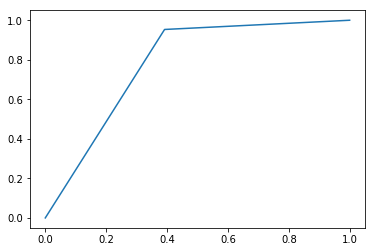

In [56]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
%matplotlib inline 

fpr,tpr,_ = roc_curve(y_val,y_val_pred)

plt.plot(fpr,tpr)

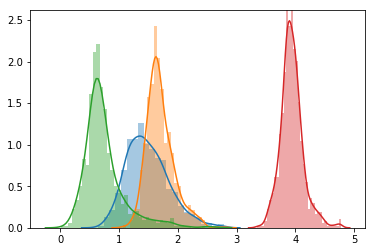

In [45]:
import seaborn as sns
%matplotlib inline
for i in [2000,4000,6000,8000]:
    sns.distplot(X_train[:,i])

ValueError: Booster.get_score() results in empty

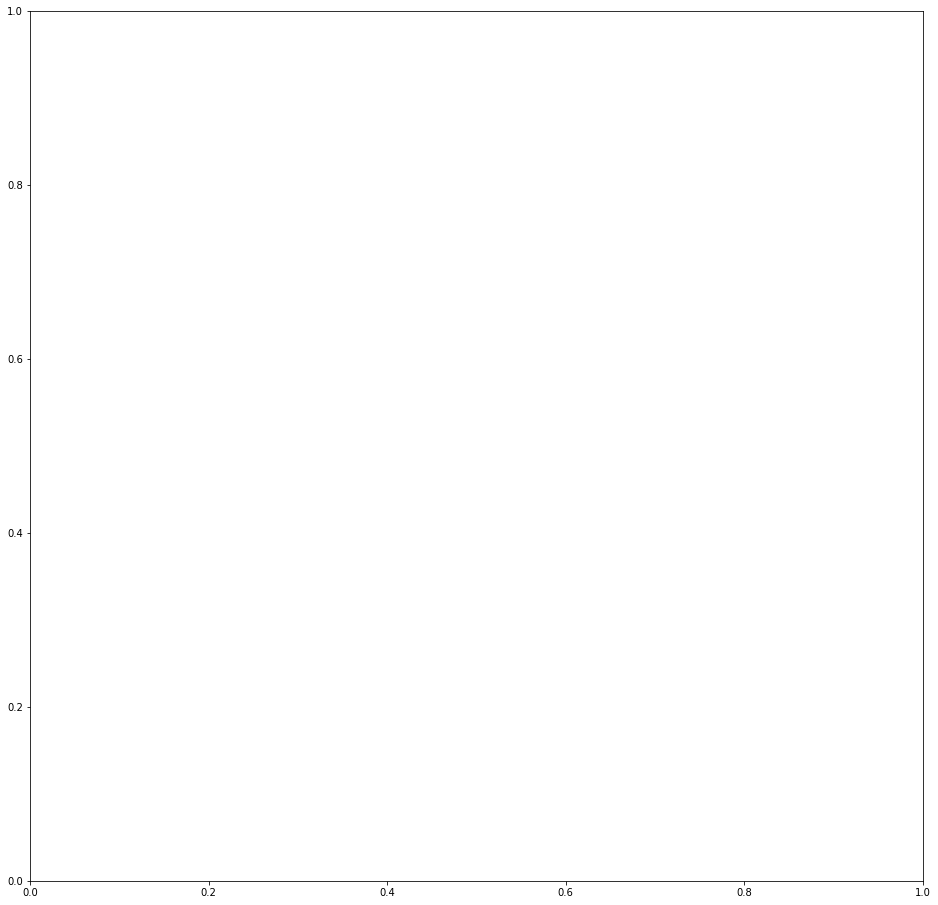

In [34]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(111)
xgb.plot_importance(clf,max_num_features=100,ax=ax,importance_type="weight")

In [39]:
X_train.shape
57666%8000


1666

In [6]:
for l in range(0,4):
    gc.collect()
    print("Training layer {}".format(l))
    getScores(l)
    notify.on_epoch_end(l*2)
#os.system("aws ec2 stop-instances --instance-ids i-0409f4210349f600d")

Training layer 0
Reading data...
Fitting model...
[0]	validation_0-logloss:0.673841
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.667271
[2]	validation_0-logloss:0.666667
[3]	validation_0-logloss:0.647717
[4]	validation_0-logloss:0.646411
[5]	validation_0-logloss:0.629494
[6]	validation_0-logloss:0.622249
[7]	validation_0-logloss:0.622563
[8]	validation_0-logloss:0.621171
[9]	validation_0-logloss:0.622467
[10]	validation_0-logloss:0.613897
[11]	validation_0-logloss:0.608803
[12]	validation_0-logloss:0.610813
[13]	validation_0-logloss:0.605142
[14]	validation_0-logloss:0.599064
[15]	validation_0-logloss:0.598248
[16]	validation_0-logloss:0.601616
[17]	validation_0-logloss:0.600945
[18]	validation_0-logloss:0.602762
[19]	validation_0-logloss:0.601178
[20]	validation_0-logloss:0.599841
[21]	validation_0-logloss:0.603794
[22]	validation_0-logloss:0.60051
[23]	validation_0-logloss:0.596205
[24]	validation_0-logloss:0.596854
[25]	validation_0-